<h1 style="text-align: center;font-size: 300%;">
<span style="text-align: center; color:#FFD700;">Resultados do Hackaton de <br> Identificação de Áreas Queimadas<br> a Partir de Análise Bi-Temporal</span>
</h1>
<hr style="border:2px inset #B8860B;">
<br/>
<br/>
<div style="text-align: center; font-size: 90%; color: #B8860B;">
  <div style="display: flex; justify-content: center; align-items: flex-start;">
    <!-- Autor 3 -->
    <div style="margin: 0 10px;">
      <img src='https://raw.githubusercontent.com/L-Santiag0/Hackathon-assets/main/Joao_Victor.jpeg' width=90 style="border: 2px solid #B8860B;"/>
      <br/>
      <b>João Victor</b><br/>
      <a href='mailto:jvldsa10@hotmail.com' style="color: #B8860B;">jvldsa10@hotmail.com</a>
    </div>
    <!-- Autor 1 -->
    <div style="margin: 0 10px;">
      <img src='https://raw.githubusercontent.com/L-Santiag0/Hackathon-assets/main/Paulo_Ambrosio.webp' width=90 style="border: 2px solid #B8860B;"/>
      <br/>
      <b>Paulo E. Ambrósio</b><br/>
      <a href='mailto:peambrosio@uesc.br' style="color: #B8860B;">peambrosio@uesc.br</a>
    </div>
    <!-- Autor 2 -->
    <div style="margin: 0 10px;">
      <img src='https://raw.githubusercontent.com/L-Santiag0/Hackathon-assets/main/Lucas_Santiago.jpeg' width=90 style="border: 2px solid #B8860B;"/>
      <br/>
      <b>Lucas Santiago</b><br/>
      <a href='mailto:lscsantos.cic@uesc.br' style="color: #B8860B;">lscsantos.cic@uesc.br</a>
    </div>
  </div>
  
  <div style="margin-top: 35px;">
    Universidade Estadual de Santa Cruz - UESC
    <br/>
    Campus Soane Nazaré de Andrade, Rod. Jorge Amado, Km 16 - Salobrinho, Ilhéus - BA, 45662-900
    <br/><br/>
    Last Update: September 07, 2025
  </div>   
</div>

# **Metodologia**

Este notebook apresenta uma solução para a detecção de cicatrizes de queimadas, utilizando uma pipeline de Machine Learning que combina **Engenharia de Atributos**, um modelo de segmentação **U-Net** e um **Ensemble** Pós-processamento para refinar os resultados.


A nossa abordagem foi transformar o problema antes de apresentá-lo ao modelo. Em vez de pedir a uma rede neural para aprender a comparar as imagens pré (T1) e pós (T2) queimadas do zero, nós primeiro calculamos uma "imagem de mudança" ou "falso RGB", utilizando 3 canais baseados nos 4 índices espectrais. Esta imagem de mudança é então utilizada para treinar uma U-Net, cujo trabalho é identificar os padrões visuais que distinguem queimadas reais de outras mudanças irrelevantes.


### **Sobre o Pipeline**

Nossa solução segue um fluxo de processamento bem definido, desde os dados brutos até a predição final. O diagrama abaixo resume as principais etapas:

**[T1, T2] → `compute_indices` → [dRed, dGreen, dNBR] → `U-Net` → [Probabilidades] → `Ensemble com dNBR` → `Grid Search (th)` → [Máscara Final]**

1.  **Cálculo de Índices:** As imagens T1 e T2 são processadas para gerar uma "imagem de mudança" de 3 canais.
2.  **Inferência da U-Net:** Esta imagem de mudança é passada para a U-Net, que gera um mapa de probabilidade de queimada.
3.  **Ensemble e Otimização:** O mapa de probabilidade é combinado com o dNBR bruto, e um limiar (`th`) otimizado via Grid Search é aplicado para gerar a máscara binária final.

Nosso procedimento com a U-Net Padrão utiliza uma arquitetura que recebe uma única imagem de mudança - que nós criamos e fizemos a comparação fora do modelo, na etapa de pré-processamento.

## **Configuração do Ambiente**

As próximas duas células preparam o ambiente para a execução:
1.  **Instalação de Dependências e Importações:** Instala as bibliotecas externas e importa todos os módulos necessários.
2.  **Configuração Global:** Centraliza todos os caminhos de arquivos e hiperparâmetros em um único local para fácil modificação e reprodutibilidade.

In [2]:
# ----- Instalação de Dependências e Importações -----

# --- Instalação de Bibliotecas Necessárias ---
%pip install -q --upgrade pandas numpy matplotlib tqdm opencv-python scikit-learn segmentation-models-pytorch timm albumentations rasterio

# --- Manipulação de Arquivos e Sistema Operacional ---
import os, glob, shutil

# --- Processamento e Análise de Dados ---
import numpy as np
import pandas as pd
from tqdm import tqdm

# --- Processamento de Imagem e Dados Geoespaciais ---
import cv2
import rasterio

# --- Visualização de Dados ---
import matplotlib.pyplot as plt

# --- Torch e utilitários ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# --- Albumentations para data augmentations ---
import albumentations as A

# --- segmentation_models_pytorch (U-Net) ---
import segmentation_models_pytorch as smp

# --- Sklearn métricas para medir a perfomance ---
from sklearn.metrics import roc_auc_score, roc_curve

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### **Sobre Pastas e Arquivos Utilizados**

A tabela a seguir descreve as constantes, definidas na célula abaixo, que apontam para os diretórios e arquivos essenciais para a execução deste notebook.

| Constante | Descrição |
| :--- | :--- |
| **DATASET_T1** | Caminho para a pasta com as imagens de satélite antes da queimada (T1). |
| **DATASET_T2** | Caminho para a pasta com as imagens de satélite após a queimada (T2). |
| **DATASET_MASK** | Caminho para a pasta com as máscaras de gabarito. |
| **AVALIACAO_T1 / T2**| Caminhos para as pastas do conjunto de avaliação, usadas para gerar a submissão final. |
| **MODEL_CHECKPOINT_PATH**| Caminho completo para o nosso melhor modelo U-Net treinado (`unet_best.pth`). |
| **OUT_DIR** | Diretório de saída onde os resultados (como `submission.csv`) serão salvos. |

In [14]:
# ----- Configuração Global -----

# --- Caminhos ---
DATASET_T1 = "../dataset_kaggle/dataset/t1"
DATASET_T2 = "../dataset_kaggle/dataset/t2"
DATASET_MASK = "../dataset_kaggle/dataset/mask"
AVALIACAO_T1 = "../dataset_kaggle/avaliacao/t1"
AVALIACAO_T2 = "../dataset_kaggle/avaliacao/t2"
# Backup dos resultados
OUT_DIR = "outputs"

# --- Caminho para o modelo treinado ---
MODEL_CHECKPOINT_PATH = "unet_best.pth"

# --- Hiperparâmetros ---
IMG_SIZE = (128, 128)
BATCH_SIZE = 8
NUM_WORKERS = 0
MIN_AREA = 20
MORPH_K = 3

os.makedirs(OUT_DIR, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo definido para: {DEVICE}")

Dispositivo definido para: cpu


## **Pré-processamento e Engenharia de Atributos**

Esta seção contém as funções responsáveis por transformar os dados brutos (imagens T1 e T2) na entrada informativa que nosso modelo utilizará.

*   `robust_norm`: Uma função auxiliar para normalizar os dados de forma robusta, removendo o efeito de outliers ao cortar os percentis extremos.
*   `compute_indices`: Uma função que recebe os caminhos das imagens T1 e T2, lê as 4 bandas e calcula a diferença temporal para as bandas `Red` e `Green`, além do **dNBR (delta Normalized Burn Ratio)**. O resultado é um dicionário contendo os 3 canais que formarão nossa "imagem de mudança".

In [15]:
# ----- Definição das Funções de Processamento de Imagem -----

def robust_norm(arr, low=2, high=98):
    """Normaliza um array cortando percentis para remover outliers."""
    p1, p2 = np.percentile(arr, (low, high)); arr = np.clip(arr, p1, p2)
    return (arr - p1) / (p2 - p1 + 1e-8)

def compute_indices(t1_path, t2_path):
    """Lê T1 e T2, retorna dNBR e outras diferenças de bandas com a ordem correta."""
    with rasterio.open(t1_path) as s1: t1 = s1.read().astype(np.float32)
    with rasterio.open(t2_path) as s2: t2 = s2.read().astype(np.float32)
    R1, G1, N1, S1 = t1[0], t1[1], t1[2], t1[3]; R2, G2, N2, S2 = t2[0], t2[1], t2[2], t2[3]
    nbr1 = (N1 - S1) / (N1 + S1 + 1e-8); nbr2 = (N2 - S2) / (N2 + S2 + 1e-8)
    return {'dnbr': robust_norm(nbr1 - nbr2), 'dRed': robust_norm(R2 - R1), 'dGreen': robust_norm(G2 - G1)}

## **Carregamento do Modelo e Preparação dos Dados**

A próxima célula prepara os componentes finais para a inferência:

*   **Carrega o Modelo:** Recria a arquitetura da U-Net e carrega os pesos do nosso melhor modelo (`unet_best.pth`), que foi treinado previamente.
*   **Define o `SegDataset`:** Uma classe customizada do PyTorch que, para cada amostra, executa a função `compute_indices` e carrega a máscara de gabarito correspondente.
*   **Cria o `DataLoader` de validação**, que será usado nas etapas de avaliação e visualização.

In [16]:
# ----- Carregamento do Modelo e Recriação dos DataLoaders -----

print(f"Tentando carregar o modelo de: {MODEL_CHECKPOINT_PATH}")

# --- Recriar a arquitetura do modelo ---
ENCODER = "efficientnet-b0"
unet_model = smp.Unet(encoder_name=ENCODER, encoder_weights=None, in_channels=3, classes=1, activation=None).to(DEVICE)

# --- Carregar os pesos salvos no modelo ---
if os.path.exists(MODEL_CHECKPOINT_PATH):
    unet_model.load_state_dict(torch.load(MODEL_CHECKPOINT_PATH, map_location=DEVICE))
    print("Sucesso! Pesos do modelo carregados.")
else:
    raise FileNotFoundError(f"ERRO: Checkpoint não encontrado em '{MODEL_CHECKPOINT_PATH}'. Verifique o caminho.")

# --- Definição da classe SegDataset ---
class SegDataset(Dataset):
    def __init__(self, t1_dir, t2_dir, mask_dir, transform=None):
        self.t1_files = sorted([f for f in os.listdir(t1_dir) if f.lower().endswith(".tif")])
        self.t1_dir, self.t2_dir, self.mask_dir, self.transform = t1_dir, t2_dir, mask_dir, transform
    def __len__(self): return len(self.t1_files)
    def __getitem__(self, idx):
        fname = self.t1_files[idx]
        f1 = os.path.join(self.t1_dir, fname); f2 = os.path.join(self.t2_dir, fname); mask_path = os.path.join(self.mask_dir, fname)
        idxs = compute_indices(f1, f2)
        img = np.stack([idxs['dRed'], idxs['dGreen'], idxs['dnbr']], axis=-1)
        img = (img * 255).astype(np.uint8)
        with rasterio.open(mask_path) as src: mask = src.read(1)
        mask = (mask > 0).astype(np.uint8)
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']
        img = np.transpose(img, (2,0,1)).astype(np.float32) / 255.0
        mask = np.expand_dims(mask, 0).astype(np.float32)
        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

# --- Criação dos DataLoaders ---
# Dataset com augmentations para o Grid Search e Curva ROC
train_transform = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.RandomRotate90(p=0.5)])
full_dataset = SegDataset(DATASET_T1, DATASET_T2, DATASET_MASK, transform=train_transform)
val_split = int(0.2 * len(full_dataset))
_, val_ds = torch.utils.data.random_split(full_dataset, [len(full_dataset)-val_split, val_split], generator=torch.Generator().manual_seed(42))
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Cria um segundo dataset de validação SEM augmentations, apenas para visualização
full_dataset_no_aug = SegDataset(DATASET_T1, DATASET_T2, DATASET_MASK, transform=None)
_, val_ds_no_aug = torch.utils.data.random_split(full_dataset_no_aug, [len(full_dataset_no_aug)-val_split, val_split], generator=torch.Generator().manual_seed(42))

print("\nDataset e DataLoaders recriados com sucesso.")

Tentando carregar o modelo de: unet_best.pth
Sucesso! Pesos do modelo carregados.

Dataset e DataLoaders recriados com sucesso.


## **Processo de Treinamento**

A U-Net carregada nesta sessão foi treinada previamente com a seguinte configuração, focada em aprender a segmentar as "imagens de mudança" que criamos.

*   **Arquitetura:** Foi utilizada uma **U-Net** com um encoder **EfficientNet-B0**, pré-treinado na ImageNet. Baixamos os pesos oficiais pelo **Hugging Face**.
*   **Dados de Entrada:** O modelo foi treinado usando a composição de 3 canais (`dRed`, `dGreen`, `dNBR`) como entrada, e as máscaras de gabarito da pasta `DATASET_MASK` como rótulos.
*   **Dataset:** O conjunto de dados foi dividido em 80% para treino e 20% para validação. Aumentos de dados (rotações e flips) foram aplicados ao conjunto de treino para aumentar a robustez do modelo.
*   **Otimizador** Usamos o otimizador **Adam** com uma taxa de aprendizado de `1e-4`. 
*   **Função de Perda:** A função de perda foi uma combinação de **Binary Cross-Entropy** e **Dice Loss**, para lidar com o desbalanceamento entre pixels de queimada e de fundo.
*   **Epochs** O modelo foi treinado por 100 épocas. 
*   **Checkpointing:** Ao final de cada época, a performance era medida no conjunto de validação usando a métrica **AUC**. O checkpoint com a **maior AUC** foi salvo como `unet_best.pth`.

Este processo garante que o modelo aprendeu a identificar os padrões espaciais e de textura que distinguem uma queimada real de outras mudanças ambientais.

## **Inferência e Submissão**

Com o modelo treinado e carregado, a pipeline final consiste em duas etapas:

1.  **Grid Search:** Para refinar a decisão final, combinamos a saída da U-Net, que são probabilidades de onde ela acredita que estão as queimadas ou não, com o mapa de `dNBR` bruto, através de uma média ponderada. Um Grid Search é executado no conjunto de validação para encontrar os melhores pesos (`w1`, `w2`) e o melhor limiar (`th`) para esta combinação.
2.  **Inferência Final:** Usando os parâmetros encontrados, o modelo realiza a inferência no conjunto de avaliação. A máscara resultante passa por um pós-processamento com operações morfológicas para remover ruídos antes de ser formatada para o arquivo `submission.csv`.

In [17]:
# ----- Otimização de Parâmetros com Grid Search -----

# --- Preparação dos dados ---
val_indices = val_ds.indices
full_t1_files = full_dataset.t1_files
val_file_names = [full_t1_files[i] for i in val_indices]
val_dnbrs, val_masks_gt, unet_probs = [], [], []
unet_model.eval()

# Desativa o cálculo de gradientes para acelerar a inferência, pois não vamos treinar.
with torch.no_grad():
    for fname in tqdm(val_file_names, desc="Pré-calculando para Grid Search"):
        t1p = os.path.join(DATASET_T1, fname); t2p = os.path.join(DATASET_T2, fname)
        idxs = compute_indices(t1p, t2p)
        val_dnbrs.append(idxs['dnbr'])
        mask_path = os.path.join(DATASET_MASK, fname)
        with rasterio.open(mask_path) as src: gt_mask = src.read(1)
        val_masks_gt.append((gt_mask > 0).astype(np.uint8))
        inp = np.stack([idxs['dRed'], idxs['dGreen'], idxs['dnbr']], axis=-1)
        inp_t = torch.tensor(np.transpose((inp*255).astype(np.float32),(2,0,1))/255.0).unsqueeze(0).to(DEVICE)
        unet_probs.append(torch.sigmoid(unet_model(inp_t)).cpu().numpy().squeeze())

# --- Busca pelos melhores parâmetros ---
weights = [(0.7,0.3), (0.6,0.4), (0.8,0.2), (0.9,0.1), (0.5, 0.5)]
threshs = np.linspace(0.2, 0.5, 10)
best = {"auc": -1}
for w1, w2 in weights:
    for th in threshs:
        y_true, y_score = [], []
        for prob_map, dnbr_map, gt in zip(unet_probs, val_dnbrs, val_masks_gt):
            final = w1*prob_map + w2*dnbr_map
            y_score.extend(final.flatten().tolist()); y_true.extend(gt.flatten().tolist())
        auc = roc_auc_score(y_true, y_score) if y_true else 0.0
        if auc > best["auc"]: best = {"auc": auc, "w1": w1, "w2": w2, "th": th}
print("\nMelhores parâmetros encontrados (val):", best)
pd.DataFrame([best]).to_csv(os.path.join(OUT_DIR, "ensemble_best.csv"), index=False)

Pré-calculando para Grid Search: 100%|██████████| 189/189 [00:28<00:00,  6.57it/s]



Melhores parâmetros encontrados (val): {'auc': 0.9779738123110664, 'w1': 0.9, 'w2': 0.1, 'th': np.float64(0.2)}


In [18]:
# ----- Geração do Arquivo de Submissão -----

# --- Carrega parâmetros otimizados ---
best = pd.read_csv(os.path.join(OUT_DIR, "ensemble_best.csv")).iloc[0].to_dict()
w1, w2, th = float(best["w1"]), float(best["w2"]), float(best["th"])

# --- Inferência no conjunto de avaliação ---
eval_files = sorted([f for f in os.listdir(AVALIACAO_T1) if f.lower().endswith(".tif")])
submission_rows = []
unet_model.eval()
for fname in tqdm(eval_files, desc="Inferindo no conjunto de avaliação"):
    t1p = os.path.join(AVALIACAO_T1, fname); t2p = os.path.join(AVALIACAO_T2, fname)
    idxs = compute_indices(t1p, t2p)
    inp = np.stack([idxs['dRed'], idxs['dGreen'], idxs['dnbr']], axis=-1)
    inp_t = torch.tensor(np.transpose((inp*255).astype(np.float32),(2,0,1))/255.0).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        prob = torch.sigmoid(unet_model(inp_t)).cpu().numpy().squeeze()
    final_score = w1*prob + w2*idxs['dnbr']
    binmask = (final_score >= th).astype(np.uint8)
    # --- Pós-processamento da máscara ---
    kernel = np.ones((MORPH_K,MORPH_K),np.uint8)
    binmask = cv2.morphologyEx(binmask, cv2.MORPH_OPEN, kernel)
    nb, out, stats, _ = cv2.connectedComponentsWithStats(binmask, connectivity=8)
    filtered = np.zeros_like(binmask); sizes = stats[1:, -1]
    for i, s in enumerate(sizes):
        if s >= MIN_AREA: filtered[out == (i+1)] = 1
    submission_rows.append([fname] + filtered.flatten().tolist())

# --- Salvar o arquivo CSV ---
header = ["id"] + [f"pixel_{i}" for i in range(IMG_SIZE[0]*IMG_SIZE[1])]
out_path = os.path.join(OUT_DIR, "submission.csv")
pd.DataFrame(submission_rows, columns=header).to_csv(out_path, index=False)
print(f"\nArquivo de submissão salvo em: {out_path}")

Inferindo no conjunto de avaliação: 100%|██████████| 315/315 [00:35<00:00,  8.79it/s]



Arquivo de submissão salvo em: outputs\submission.csv


## **Resultados**

Para avaliar a qualidade do nosso modelo, utilizamos a métrica da competição (curva ROC-AUC), calculada em nível de pixel no conjunto de validação.

Também utilizamos algumas amostras de visualização para inspecionar qualitativamente os resultados, comparando a imagem de entrada, o gabarito real e a predição final do nosso ensemble.

### CURVA ROC-AUC

Calculando predições no conjunto de validação para a curva ROC...


Validando: 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]



Performance final no conjunto de validação:
AUC (nível de pixel): 0.9784


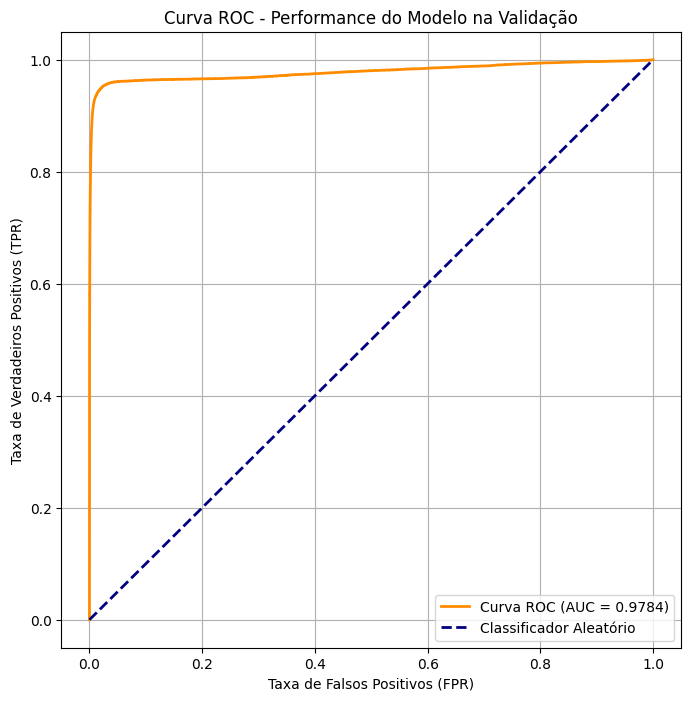

In [19]:
all_labels, all_preds = [], []
unet_model.eval()
print("Calculando predições no conjunto de validação para a curva ROC...")
with torch.no_grad():
    for imgs, masks in tqdm(val_loader, desc="Validando"):
        imgs = imgs.to(DEVICE)
        outputs = unet_model(imgs)
        preds = torch.sigmoid(outputs)
        all_labels.extend(masks.cpu().numpy().ravel())
        all_preds.extend(preds.cpu().numpy().ravel())

auc = roc_auc_score(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)
print(f"\nPerformance final no conjunto de validação:")
print(f"AUC (nível de pixel): {auc:.4f}")

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Classificador Aleatório')
plt.xlabel('Taxa de Falsos Positivos (FPR)'); plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Performance do Modelo na Validação'); plt.legend(loc="lower right"); plt.grid(True)
plt.show()

### Visualização de Amostras


--- Visualização Pós-Treino ---
Index de validação: 47 | Nome: recorte_655.tif | Max score: 0.9998 | Threshold: 0.2000


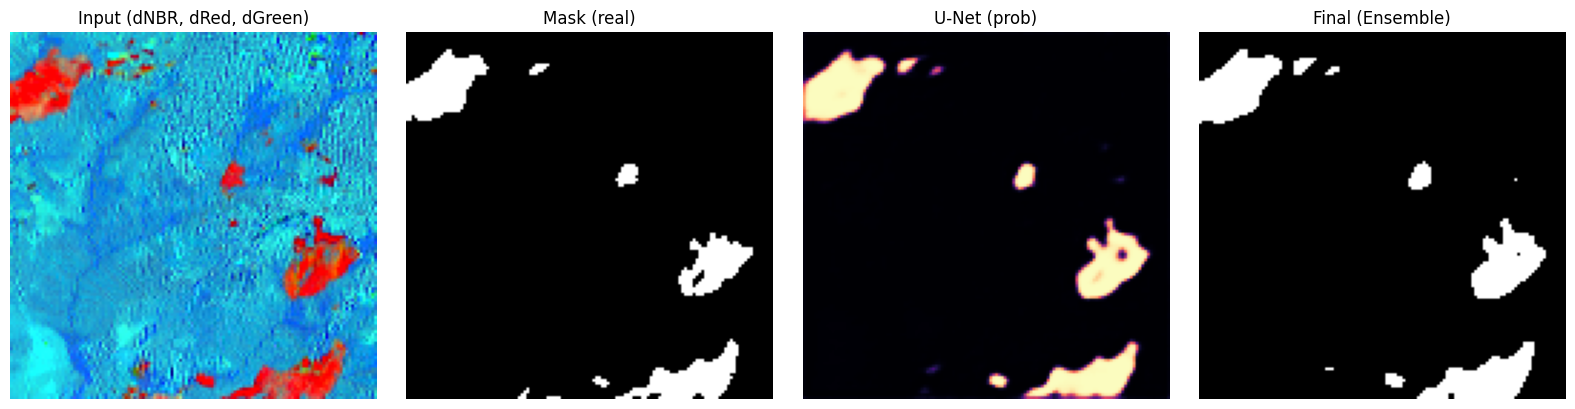

Index de validação: 55 | Nome: recorte_329.tif | Max score: 0.9766 | Threshold: 0.2000


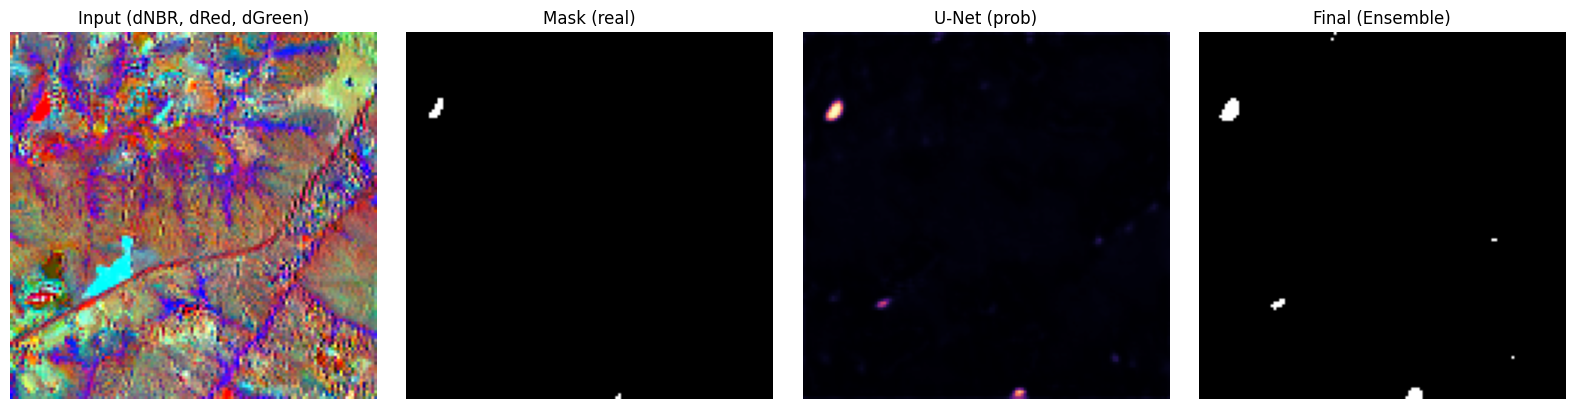

Index de validação: 78 | Nome: recorte_188.tif | Max score: 0.9993 | Threshold: 0.2000


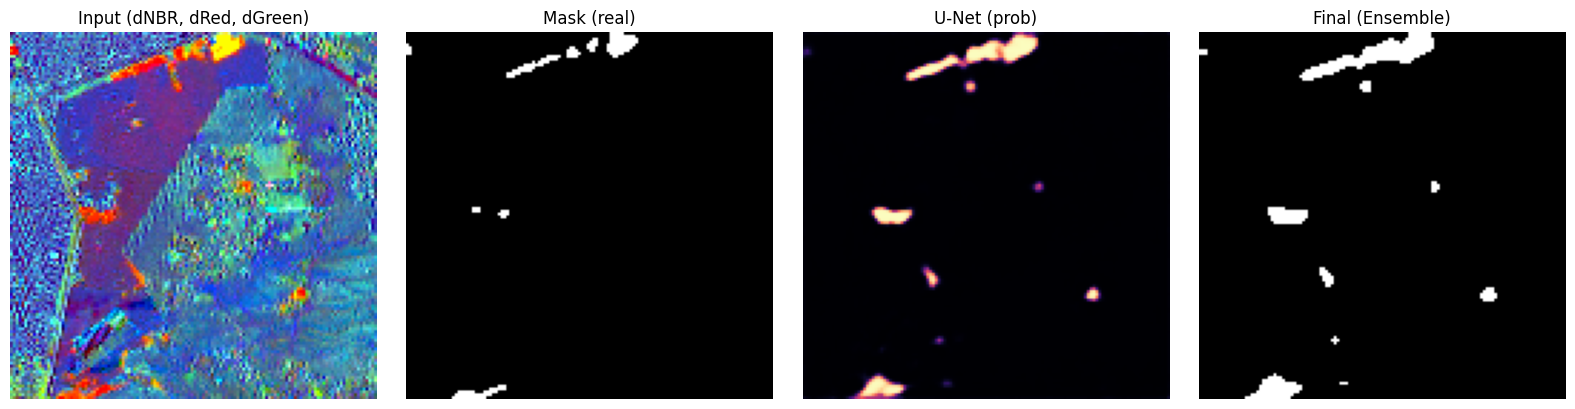

In [20]:
def visualize_val_sample(idx=0, w1=0.7, w2=0.3, th=0.3):
    # Usamos o dataset de validação SEM augmentations, para a visualização.
    val_indices = val_ds_no_aug.indices
    full_files_list = full_dataset_no_aug.t1_files

    idx_in_full_dataset = val_indices[idx]
    fname = full_files_list[idx_in_full_dataset]

    _, mask_gt_tensor = val_ds_no_aug[idx]
    mask_gt = mask_gt_tensor.squeeze().cpu().numpy()

    f1 = os.path.join(DATASET_T1, fname); f2 = os.path.join(DATASET_T2, fname)
    idxs = compute_indices(f1, f2)

    # Prepara a entrada para o modelo e faz a predição
    inp_model = np.stack([idxs['dRed'], idxs['dGreen'], idxs['dnbr']], axis=-1)
    inp_t = torch.tensor(np.transpose((inp_model*255).astype(np.float32),(2,0,1))/255.0).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        prob = torch.sigmoid(unet_model(inp_t)).cpu().numpy().squeeze()

    # Cria a imagem de exibição 
    inp_display = np.stack([idxs['dnbr'], idxs['dRed'], idxs['dGreen']], axis=-1)

    # Lógica do Ensemble para a máscara final
    final_score = w1*prob + w2*idxs['dnbr']
    final_mask = ((final_score >= th) * 255).astype(np.uint8)

    print(f"Index de validação: {idx} | Nome: {fname} | Max score: {final_score.max():.4f} | Threshold: {th:.4f}")

    fig, axs = plt.subplots(1, 4, figsize=(16,4))
    axs[0].imshow(inp_display); axs[0].set_title("Input (dNBR, dRed, dGreen)")
    axs[1].imshow(mask_gt, cmap="gray"); axs[1].set_title("Mask (real)")
    axs[2].imshow(prob, cmap="magma"); axs[2].set_title("U-Net (prob)")
    axs[3].imshow(final_mask, cmap="gray"); axs[3].set_title("Final (Ensemble)")
    for ax in axs: ax.axis("off")
    plt.tight_layout()
    plt.show()

print("\n--- Visualização Pós-Treino ---")
visualize_val_sample(idx=47, w1=best['w1'], w2=best['w2'], th=best['th'])
visualize_val_sample(idx=55, w1=best['w1'], w2=best['w2'], th=best['th'])
visualize_val_sample(idx=78, w1=best['w1'], w2=best['w2'], th=best['th'])